In [1]:
library(dplyr)
library(randomForest)
library(caret)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



In [2]:
heart=read.csv('../Data/t3/heart 2.csv')

In [3]:

#1. Age	나이 (int)
#2. Sex	성별 (1, 0 / int)
#3. ChestPainType	가슴 통증 타입 (0 ~ 3 / int)
#4. RestingBP	혈압
#5. Cholesterol혈청 콜레스테롤
#6. FastingBS > 120 mg/dl	공복 혈당
#7. RestingECG	심전도
#8. MaxHR	최대 심장박동 수
#9. ExerciseAngina	운동 유도 협심증 (이게 뭐죠?)
#10. Oldpeak = ST depression induced by exercise relative to rest	노약 =운동에 의해 유발되는 St 우울증 (이건 또 뭐죠?)
#11. ST_Slope	ST 세그먼트의 기울기


In [4]:
colSums(is.na(heart))# na 확인

Age            Sex  ChestPainType      RestingBP    Cholesterol 
             0              0              0              0              0 
     FastingBS     RestingECG          MaxHR ExerciseAngina        Oldpeak 
             0              0              0              0              0 
      ST_Slope   HeartDisease 
             0              0

In [5]:
heart=heart%>%arrange(desc(HeartDisease)) # 타겟순으로 

In [6]:
heart$HeartDisease%>%table# 4:6 정도비율

.
  0   1 
410 508 

In [7]:
library(stringr)
heart%>%str

'data.frame':	918 obs. of  12 variables:
 $ Age           : int  49 48 37 58 49 38 60 36 44 53 ...
 $ Sex           : Factor w/ 2 levels "F","M": 1 1 2 2 2 2 2 2 2 2 ...
 $ ChestPainType : Factor w/ 4 levels "ASY","ATA","NAP",..: 3 1 1 2 1 1 1 2 2 3 ...
 $ RestingBP     : int  160 138 140 136 140 110 100 120 150 145 ...
 $ Cholesterol   : int  180 214 207 164 234 196 248 267 288 518 ...
 $ FastingBS     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ RestingECG    : Factor w/ 3 levels "LVH","Normal",..: 2 2 2 3 2 2 2 2 2 2 ...
 $ MaxHR         : int  156 108 130 99 140 166 125 160 150 130 ...
 $ ExerciseAngina: Factor w/ 2 levels "N","Y": 1 2 2 2 2 1 1 1 2 1 ...
 $ Oldpeak       : num  1 1.5 1.5 2 1 0 1 3 3 0 ...
 $ ST_Slope      : Factor w/ 3 levels "Down","Flat",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ HeartDisease  : int  1 1 1 1 1 1 1 1 1 1 ...


[1] 334

[1] 197

[1] 0

[1] 498

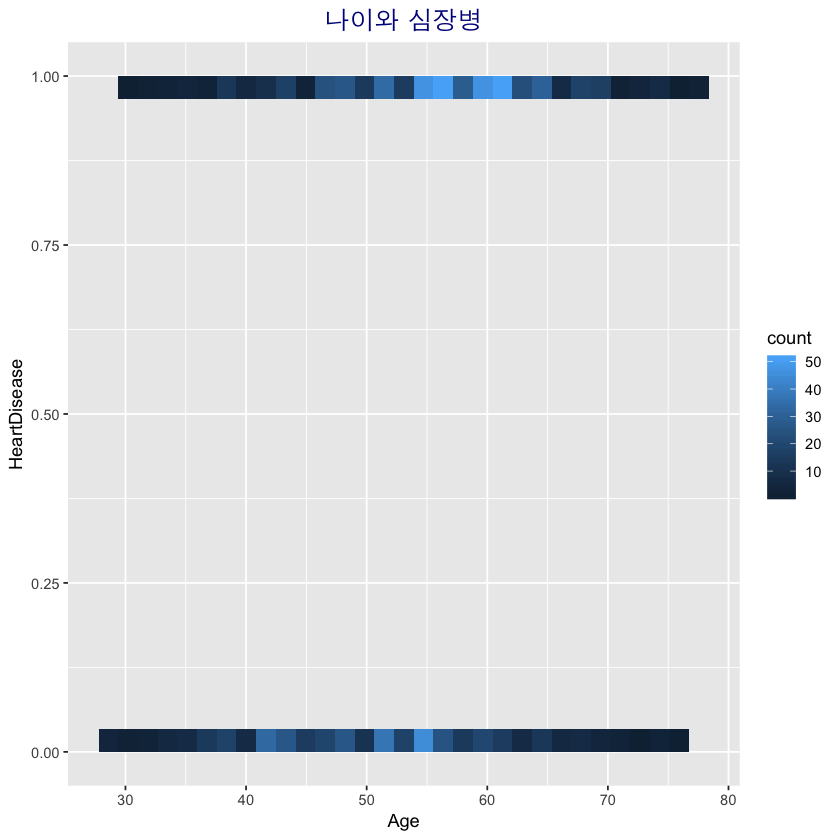

In [8]:
# 공부시킬 칼럼들 정하기 
options(warn = -1)

heart%>%filter(Age >=54)%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(Age <=54)%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(Age >=54)%>%filter(Sex == '1')%>%nrow
heart%>%filter(Age >=54)%>%filter(Sex != '1')%>%nrow
# 나이의 중간값인 54 기준 고령자일수록 심장질환자가 훨씬 많다  
# 이중고령자 여성 심장질환 보유자가 압도적으로 많음 

ggplot(data=heart,aes(x=Age,y=HeartDisease))+geom_bin2d()+ ggtitle("나이와 심장병") +   
theme(plot.title = element_text(family = "AppleGothic", 
face = "bold", hjust = 0.5, size = 15, color = "darkblue")) 


[1] 117

[1] 61

[1] 285

[1] 267

[1] 106

[1] 82

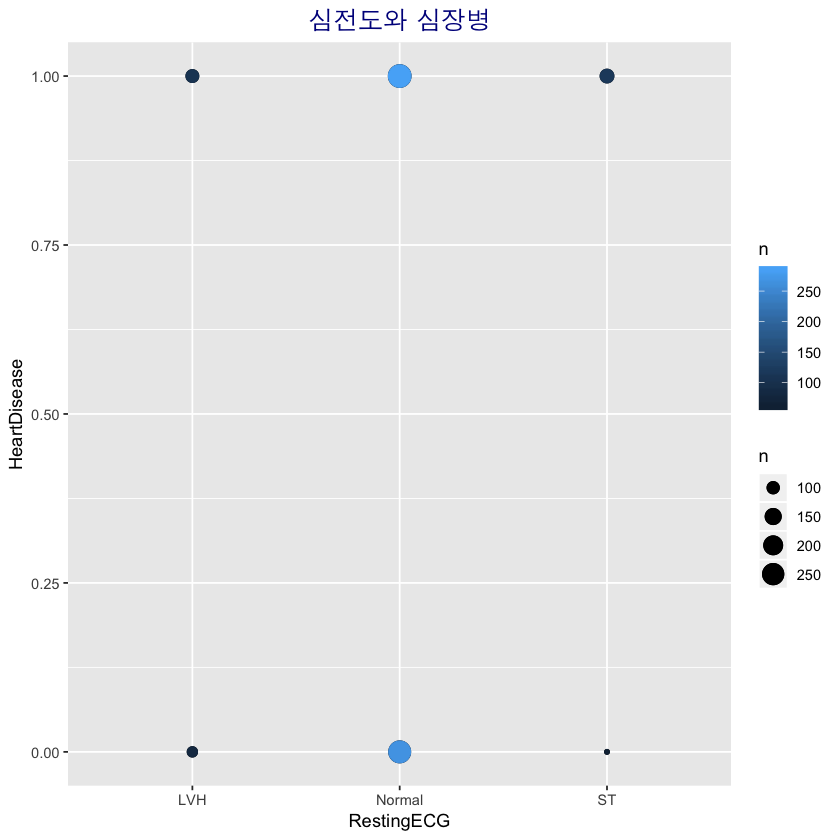

In [9]:
heart%>%filter(RestingECG=="ST")%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(RestingECG=="ST")%>%filter(HeartDisease!='1')%>%nrow
heart%>%filter(RestingECG=="Normal")%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(RestingECG=="Normal")%>%filter(HeartDisease!='1')%>%nrow
heart%>%filter(RestingECG=="LVH")%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(RestingECG=="LVH")%>%filter(HeartDisease!='1')%>%nrow
# 심전도가 Normal 이거나 lvh라고해서 더 많이걸리는건 아니란걸 확인 허나 st 일경우 약간의 관계가있어보인다
ggplot(data=heart,aes(x=RestingECG,y=HeartDisease))+geom_count() + geom_count(aes(color = ..n..))+ggtitle("심전도와 심장병") +   
  theme(plot.title = element_text(family = "AppleGothic", face = "bold", hjust = 0.5, size = 15, color = "darkblue")) 


In [10]:
heart$RestingBP%>%summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   120.0   130.0   132.4   140.0   200.0 

In [11]:
heart%>%filter(RestingBP>='120')%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(RestingBP>='120')%>%filter(HeartDisease!='1')%>%nrow
heart%>%filter(RestingBP<='120')%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(RestingBP<='120')%>%filter(HeartDisease!='1')%>%nrow
# 정상혈압 기준인 120을 기준으루 심장유무 수를 판단한결과 
# 혈압이 낮은사람은 심장질환에 걸린 비율도 높다고 심장질환에 걸린비율도 둘다 5:5 4:6 이다 향후  교육때 꼭필요한 타겟은 아닐거같다.
# ggplot(data=heart,aes(x=RestingBP,y=HeartDisease))+
# geom_count() + geom_count(aes(color = ..n..))+ggtitle("혈압과 심장병") 
# +theme(plot.title = element_text(family = "AppleGothic", 
# face = "bold", hjust = 0.5, size = 15, color = "darkblue")) 


[1] 428

[1] 341

[1] 135

[1] 146

In [12]:
heart$Cholesterol%>%summary

##https://www.hidoc.co.kr/healthstory/news/C0000587263
# 콜레스테롤 심장질환 관련 기사 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   173.2   223.0   198.8   267.0   603.0 

[1] 338

[1] 366

[1] 170

[1] 44

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   173.2   223.0   198.8   267.0   603.0 

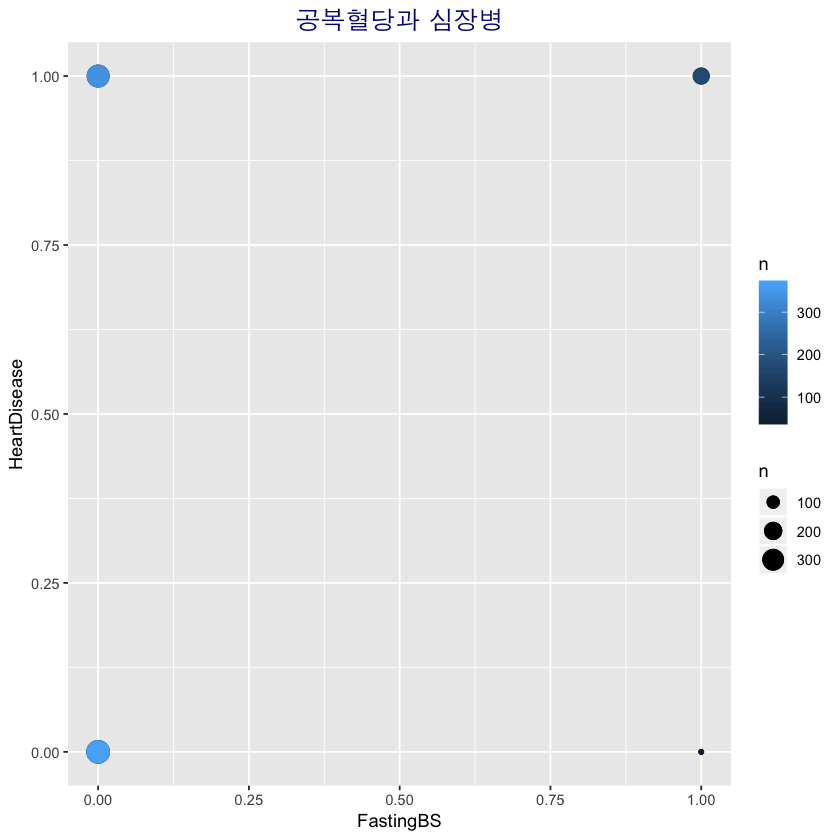

In [13]:
heart%>%filter(FastingBS=="0")%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(FastingBS=="0")%>%filter(HeartDisease!='1')%>%nrow
heart%>%filter(FastingBS=="1")%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(FastingBS=="1")%>%filter(HeartDisease!='1')%>%nrow
# 공복혈당이 높은사람들중 심장질환 보유자수가 압도적으로 높다 예측률에 큰영향을 줄것으로 보임
heart$Cholesterol%>%summary
ggplot(data=heart,aes(x=FastingBS,y=HeartDisease))+geom_count() + geom_count(aes(color = ..n..))+ggtitle("공복혈당과 심장병") +   
  theme(plot.title = element_text(family = "AppleGothic", face = "bold", hjust = 0.5, size = 15, color = "darkblue"))



In [14]:
heart$MaxHR%>%summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   120.0   138.0   136.8   156.0   202.0 

[1] 179

[1] 334

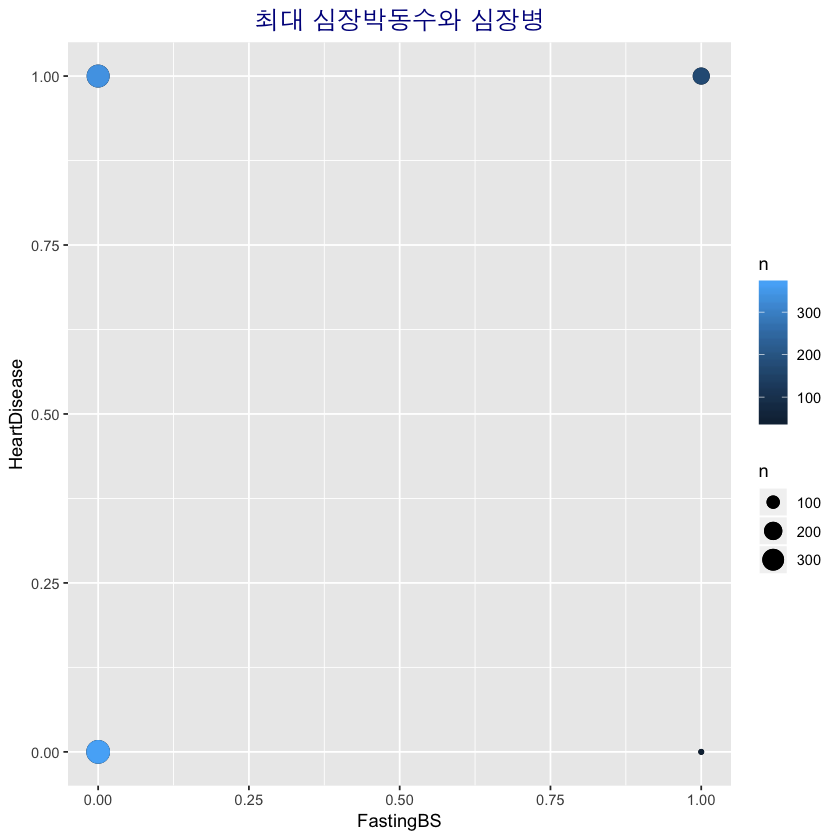

In [15]:
heart%>%filter(MaxHR >=138.0)%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(MaxHR <=138.0)%>%filter(HeartDisease=='1')%>%nrow
#최대 심장박동수가 중간값인 138보다 낮은 사람들의 수가 2배가량 높은걸로보아 예측률에 영향 있을걸로 보임
ggplot(data=heart,aes(x=FastingBS,y=HeartDisease))+geom_count() + geom_count(aes(color = ..n..))+ggtitle("최대 심장박동수와 심장병") +   
  theme(plot.title = element_text(family = "AppleGothic", face = "bold", hjust = 0.5, size = 15, color = "darkblue")) 


[1] 192

[1] 355

[1] 316

[1] 55

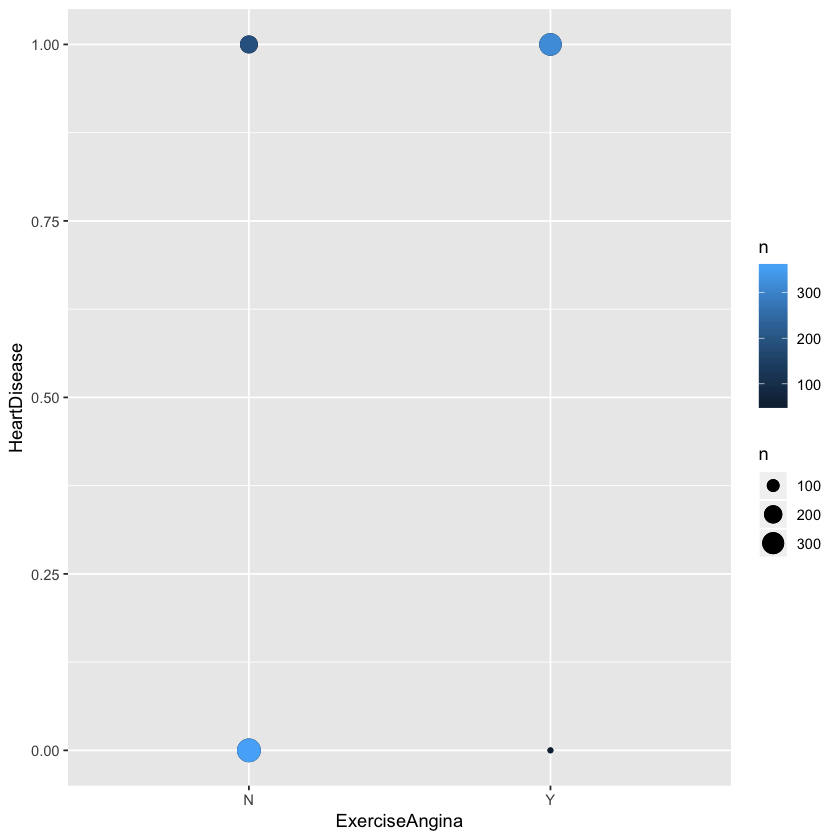

In [16]:
heart%>%filter(ExerciseAngina =="N")%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(ExerciseAngina =="N")%>%filter(HeartDisease!='1')%>%nrow
heart%>%filter(ExerciseAngina =="Y")%>%filter(HeartDisease=='1')%>%nrow
heart%>%filter(ExerciseAngina =="Y")%>%filter(HeartDisease!='1')%>%nrow
#운동 유도 협심증이 없는사람들은 심장질환이 없고 
# 있는사람들은 압도적으로 심장질환자의 수가 높은것을 확인 중요한 칼럼***
ggplot(data=heart,aes(x=ExerciseAngina,y=HeartDisease))+geom_count() + geom_count(aes(color = ..n..))


In [17]:
heart

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,1
49,M,ASY,140,234,0,Normal,140,Y,1.0,Flat,1
38,M,ASY,110,196,0,Normal,166,N,0.0,Flat,1
60,M,ASY,100,248,0,Normal,125,N,1.0,Flat,1
36,M,ATA,120,267,0,Normal,160,N,3.0,Flat,1
44,M,ATA,150,288,0,Normal,150,Y,3.0,Flat,1
53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1


In [18]:
heart$Sex=str_replace_all(heart$Sex,"F","0")
heart$Sex=str_replace_all(heart$Sex,"M","1") # 성별을 수치화

In [19]:
heart$Sex=heart$Sex%>%as.numeric

In [20]:
    heart$SM=heart$Sex=='1'
heart$SF=heart$Sex=='0'

In [21]:
heart$CASY=heart$ChestPainType=='ASY'
heart$CATA=heart$ChestPainType=='ATA'
heart$CNAP=heart$ChestPainType=='NAP'
heart$CTA=heart$ChestPainType=='TA'

In [22]:
heart$RLVH=heart$RestingECG=='LVH'
heart$RN=heart$RestingECG=='Normal'
heart$RST=heart$RestingECG=='ST'


In [23]:
heart$EN=heart$ExerciseAngina=='N'
heart$EY=heart$ExerciseAngina=='Y'

In [24]:
heart$Oldpeak%>%summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.6000  0.0000  0.6000  0.8874  1.5000  6.2000 

In [25]:
heart$Oldpeak1=heart$Oldpeak <= 0
heart$Oldpeak2=heart$Oldpeak > 0&heart$Oldpeak <= 0.6
heart$Oldpeak3=heart$Oldpeak > 0.6&heart$Oldpeak <= 1.5
heart$Oldpeak4=heart$Oldpeak > 1.5&heart$Oldpeak <= 6.2 

In [26]:
heart$ST_Slope1=heart$ST_Slope=='Down'
heart$ST_Slope2=heart$ST_Slope=='Flat'
heart$ST_Slope3=heart$ST_Slope=='UP'



In [27]:
heart%>%colnames
#'RestingECG'

[1] "Age"            "Sex"            "ChestPainType"  "RestingBP"     
 [5] "Cholesterol"    "FastingBS"      "RestingECG"     "MaxHR"         
 [9] "ExerciseAngina" "Oldpeak"        "ST_Slope"       "HeartDisease"  
[13] "SM"             "SF"             "CASY"           "CATA"          
[17] "CNAP"           "CTA"            "RLVH"           "RN"            
[21] "RST"            "EN"             "EY"             "Oldpeak1"      
[25] "Oldpeak2"       "Oldpeak3"       "Oldpeak4"       "ST_Slope1"     
[29] "ST_Slope2"      "ST_Slope3"

In [28]:
heart$HeartDisease=heart$HeartDisease%>%as.factor

In [29]:
# 흔히 알수있는 나이 성별 가슴통증, 혈압만으로 측정 
set.seed(695)

samp1 <- createDataPartition(heart$HeartDisease, p = 0.7, list = F)
target_col = c('Age', 'SM','SF','CASY','CATA','CNAP','CTA','HeartDisease'
               ,'MaxHR' )

data.train <-heart[samp1,]
#검즘용
data.test <- heart[-samp1,]
train.data = data.train[target_col]
test.data = data.test[target_col]
rf= randomForest(HeartDisease ~ . , data= train.data ,mtry = 10,importance = F,ntree = 2000)
#mtry=변수개수 importance=중요성
x = subset(test.data,select = -HeartDisease)
y = test.data$HeartDisease
pred = predict(rf,x)
## 머신러닝을 2개만들어서 사용자의 정보에 따라 쪼금더 정확한 머신러닝을 선택할수 있게하는것도 방법일듯 
## 검사결과가 있는 머신러닝에서 추가되어야 할 칼럼들 
## 'FastingBS','Cholesterol',"RLVH",'RN','RST',''EN','EY','Oldpeak1','Oldpeak2','Oldpeak3',
## 'Oldpeak4','ST_Slope1','ST_Slope2','ST_Slope3'

In [34]:
mean(pred ==y )*100

[1] 77.09091

In [31]:
heart$ChestPainType%>%table

.
ASY ATA NAP  TA 
496 173 203  46 